In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Смеси Гауссовых распределений (GMM)

Смесь Гауссовых распределений (gaussian mixture model, GMM) нацелена на поиск
многомерных Гауссовых распределений вероятностей, моделирующих наилучшим
возможным образом любой исходный набор данных. 

«Под капотом» смесь Гауссовых распределений очень напоминает метод k-средних:
она использует подход с максимизацией математического ожидания, который с качественной точки зрения делает следующее.
1. Выбирает первоначальные гипотезы для расположения и формы кластеров.
2. Повторяет до достижения сходимости:
- E-шаг — для каждой точки находит веса, кодирующие вероятность ее принадлежности к каждому кластеру;
- M-шаг — для каждого кластера корректирует его расположение, нормализацию и форму на основе информации обо всех точках данных с учетом весов.

В результате каждый кластер оказывается связан не со сферой с четкой границей,
а с гладкой Гауссовой моделью

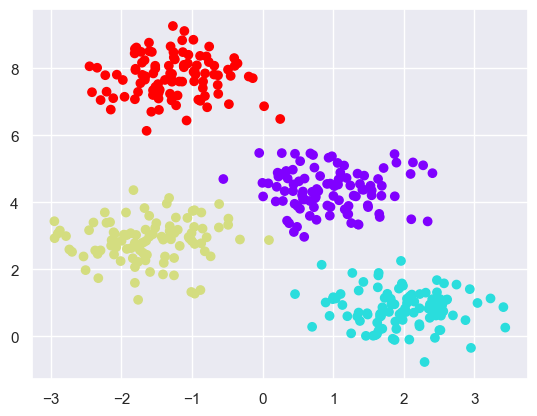

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(400, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')

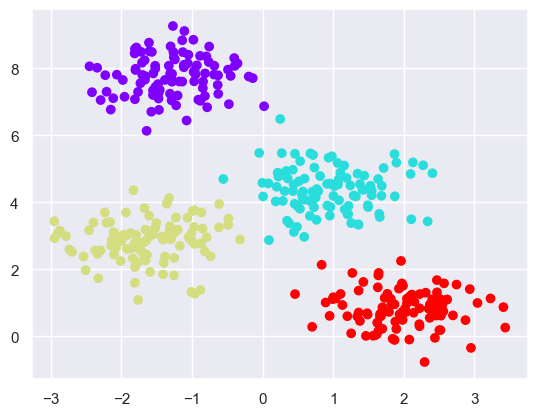

In [3]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')

In [4]:
# можно присваивать метки кластеров на вероятностной основе
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]]


Метод **predict_proba** возвращает матрицу размера [n_samples, n_clusters], содержащую оценки вероятностей принадлежности точки к конкретному кластеру

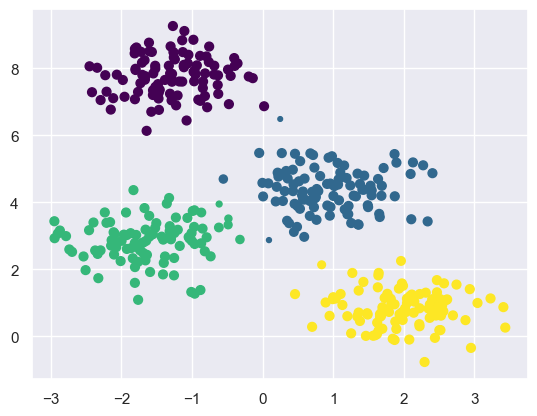

In [5]:
# визуализация этой вероятности
# размеры точек пропорциональны степени достоверности их предсказания
size = 40 * probs.max(axis=1) ** 2
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)

In [6]:
# Создадим функцию для упрощения визуализации расположений и форм кластеров метода GMM
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Рисует эллипс с заданными расположением и ковариацией"""
    ax = ax or plt.gca()
    
    # Преобразуем ковариацию к главным осям координат
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Рисуем эллипс
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

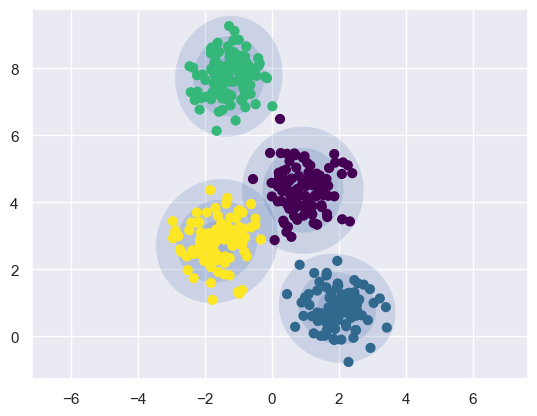

In [7]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

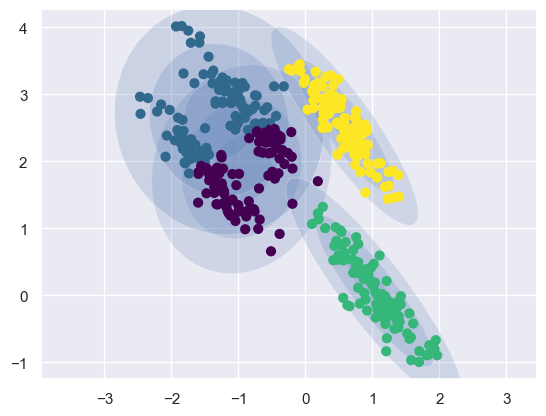

In [8]:
# для "растянутого" набора даныхх
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
# plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y, cmap='viridis')
gmm = GaussianMixture(n_components=4, covariance_type='full')
plot_gmm(gmm, X_stretched)

### Выбор типа ковариации

Гиперпараметр **covariance_type** управляет степенями свободы форм кластеров. По умолчанию — covariance_type="diag", означающее возможность независимого
задания размеров кластера по всем измерениям с выравниванием полученного
эллипса по осям координат. 

Несколько более простая и быстро работающая модель — covariance_type="spherical", ограничивающая форму кластера таким образом, что все измерения равнозначны между собой. Получающаяся в этом случае кластеризация будет аналогична методу k-средних, хотя и не полностью идентична. 

Вариант с covariance_type="full" представляет собой более сложную и требующую больших вычислительных затрат модель (особенно при росте числа измерений), в которой любой из кластеров может быть эллипсом с произвольной
ориентацией

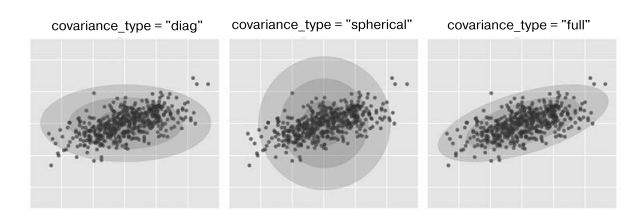

### GMM как метод оценки плотности распределения

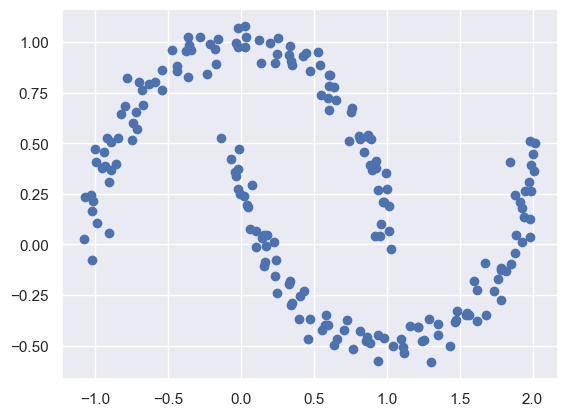

In [11]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

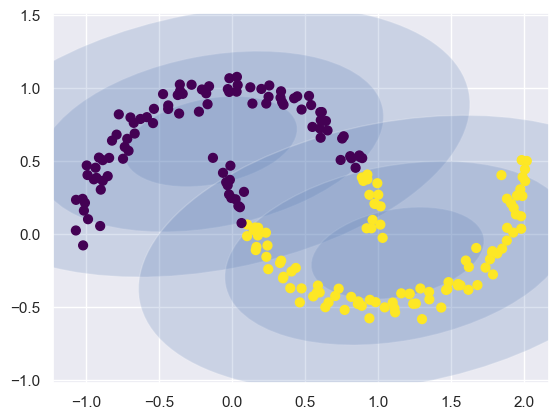

In [16]:
# двухкомпонентный GMM
gmm2 = GaussianMixture(n_components=2, covariance_type='full')
plot_gmm(gmm2, Xmoon)

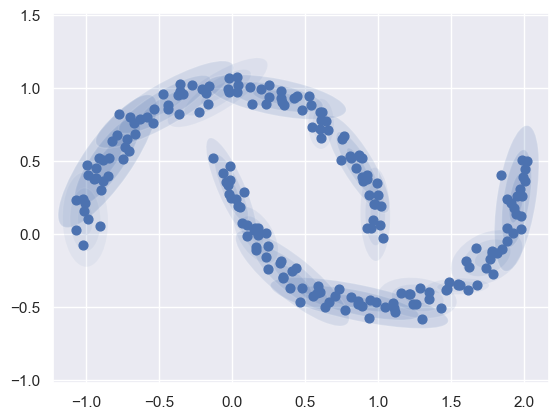

In [17]:
# больше компонент и игнорирование меток кластеров
gmm16 = GaussianMixture(n_components=16, covariance_type='full')
plot_gmm(gmm16, Xmoon, label=False)

В данном случае смесь 16 нормальных распределений служит не для поиска отдельных кластеров данных, а для моделирования общего распределения входных
данных. 

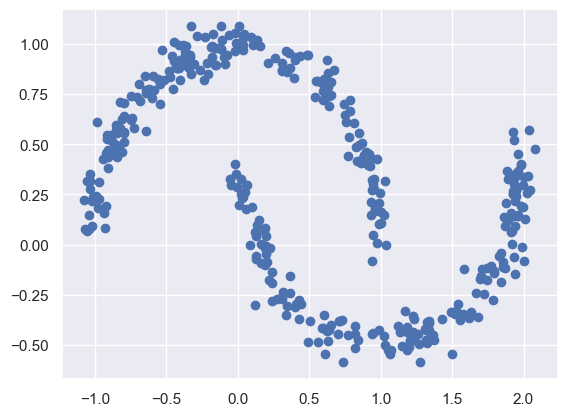

In [30]:
# новые точки
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

Метод GMM — удобное гибкое средство моделирования произвольного многомерного распределения данных

GMM — порождающая модель. Порождающая модель, по существу, представляет собой распределение вероятности для набора данных, поэтому можно легко вычислить функцию правдоподобия (likelihood function) для лежащих в ее основе данных, используя перекрестную проверку во избежание переобучения.

Другой способ введения поправки на переобучение — подстройка функции правдоподобия модели с помощью некоторого аналитического критерия, например информационного критерия Акаике (AIC) или байесовского информационного критерия (bayesian information criterion, BIC).

Оптимальное количество кластеров — то, которое минимизирует AIC или BIC

Text(0.5, 0, 'n_components')

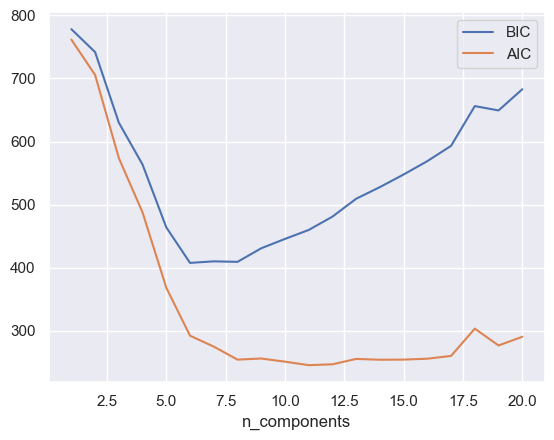

In [32]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
         for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Подобный метод выбора числа компонент представляет собой меру успешности работы GMM как оценивателя плотности распределения, а не как алгоритма кластеризации. Стоит рассматривать GMM в основном как оцениватель плотности и использовать его для кластеризации только заведомо простых наборов данных.